<a href="https://colab.research.google.com/github/ArrogantNobody/Pytorch_study/blob/main/pytorch_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://zhuanlan.zhihu.com/p/115866586

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data

EPOCH =  3
BATCH_SIZE= 50
LR= 0.001
DOWNLOAD_MINIST = True

In [3]:
train_data = torchvision.datasets.MNIST(
    root = './MINIST',  #数据集的位置
    train = True,       #如果为True则为训练集，如果为False则为测试集
    transform = torchvision.transforms.ToTensor(),   #将图片转化成取值[0,1]的Tensor用于网络处理
    download=DOWNLOAD_MINIST
)

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


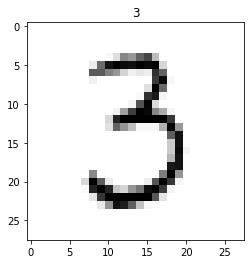

In [4]:
# plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[50].numpy(),cmap='Greys')
plt.title('%i'%train_data.train_labels[50])
plt.show()

In [5]:
train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)


test_data = torchvision.datasets.MNIST(root='./MINIST',train=False)

#只有在训练的时候才会自动压缩，所以这里采用手动压缩
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),                               #维度变换(1,28,28) --> (16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)      #维度变换(16,28,28) --> (16,14,14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),                               #维度变换(16,14,14) --> (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)      #维度变换(32,14,14) --> (32,7,7)
        )
        self.output = nn.Linear(32*7*7,10)

    def forward(self, x):
        out = self.conv1(x)                  #维度变换(Batch,1,28,28) --> (Batch,16,14,14)
        out = self.conv2(out)                #维度变换(Batch,16,14,14) --> (Batch,32,7,7)
        out = out.view(out.size(0),-1)       #维度变换(Batch,32,14,14) --> (Batch,32*14*14)||将其展平
        out = self.output(out)
        return out

In [7]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Linear(in_features=1568, out_features=10, bias=True)
)


In [8]:
for step ,(b_x,b_y) in enumerate(train_loader):
  if step == 1:
    print(b_x.shape)
    print(b_y.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


In [9]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR,)
loss_func = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step ,(b_x,b_y) in enumerate(train_loader):
        # b_x = x
        # b_y = y

        output = cnn(b_x)
        loss = loss_func(output,b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%50 ==0:
            test_output = cnn(test_x)
            # test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)



torch.save(cnn,'cnn_minist.pkl')
print('finish training')


Epoch:  0 | train loss: 2.3177 | test accuracy: 0.10
Epoch:  0 | train loss: 0.7940 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4326 | test accuracy: 0.83
Epoch:  0 | train loss: 0.1859 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2715 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3549 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3742 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1514 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2356 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1791 | test accuracy: 0.95
Epoch:  0 | train loss: 0.4489 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0680 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0728 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0927 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2426 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1256 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2662 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0489 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0256 | test accuracy

In [10]:
test_data = torchvision.datasets.MNIST(
    root='MINIST',
    train=False
)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels

cnn = torch.load('cnn_minist.pkl')

test_output = cnn(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy()

# info = torch.max(test_output,1)[1]
# print(test_output)
# print(info)

print(pred_y, 'prediction number')
print(test_y[:20].numpy(), 'real number')


test_output1 = cnn(test_x)
pred_y1 = torch.max(test_output1, 1)[1].data.numpy()
accuracy = float((pred_y1 == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('accuracy',accuracy)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] prediction number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] real number
accuracy 0.9876


In [8]:
        if step%50 == 0:
            test_output = cnn(test_x)#torch.Size([2000, 10])
            print(test_output)
            print(test_output.shape)
            pred_y = torch.max(test_output, 1)[1].data.numpy()#len(2000)
            print(torch.max(test_output, 1))#返回最大值和最大值所在的索引
#             accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)



# torch.save(cnn,'cnn_minist.pkl')
# print('finish training')

tensor([[-0.0483, -0.0633, -0.0156,  ...,  0.1496, -0.1009,  0.0780],
        [-0.0482, -0.0203,  0.0235,  ...,  0.1198, -0.1104,  0.0485],
        [-0.0610,  0.0132,  0.0244,  ...,  0.1150, -0.1026,  0.0460],
        ...,
        [-0.0511, -0.0200, -0.0053,  ...,  0.1576, -0.0968,  0.0648],
        [-0.0447, -0.0034, -0.0153,  ...,  0.1370, -0.0844,  0.0913],
        [-0.0238, -0.0445, -0.0026,  ...,  0.1438, -0.0974,  0.0743]],
       grad_fn=<AddmmBackward>)
torch.Size([2000, 10])
torch.return_types.max(
values=tensor([0.1496, 0.1258, 0.1150,  ..., 0.1576, 0.1370, 0.1438],
       grad_fn=<MaxBackward0>),
indices=tensor([7, 6, 7,  ..., 7, 7, 7]))
tensor([[-3.5117, -2.5470, -3.0658,  ...,  4.4235, -0.4685,  0.9456],
        [-2.4033, -3.3258,  2.8268,  ..., -7.2900, -0.8266, -4.3965],
        [-3.8722,  4.2221, -0.7593,  ..., -0.6063, -0.4975, -0.7155],
        ...,
        [-2.7087, -0.9251, -1.6565,  ..., -1.6170,  0.0221, -0.8695],
        [-3.5132, -1.8833, -2.3162,  ..., -1.2317,

KeyboardInterrupt: ignored